###  87점

In [1]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, Add, ZeroPadding2D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/vne

In [2]:
# load dataset list

train_data = pd.read_csv("train_preproc.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

5850 5850 2000


In [3]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 127.5 - 1   #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(5850, 128, 128, 3) (5850, 6)


In [4]:
# split dataset

train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4972, 128, 128, 3) (4972, 6)
(878, 128, 128, 3) (878, 6)


In [5]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [17]:
img_input = Input(shape=(128,128, 3))

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(img_input)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(n_class, activation='softmax')(x)
model = Model(img_input, output_tensor)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 64, 64, 64)   9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
batch_normalization_107 (BatchN (None, 64, 64, 64)   256         conv2d_107[0][0]                 
__________________________________________________________________________________________________
activation

In [19]:
with K.tf.device('/gpu:1'):
    SGD = optimizers.SGD(lr=1E-3, decay=5**(-5), momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=30)

Train on 4972 samples, validate on 878 samples
Epoch 1/30
4972/4972 [==============================] - 43s 9ms/step - loss: 2.0837 - acc: 0.4133 - val_loss: 4.8430 - val_acc: 0.4294
Epoch 2/30
4972/4972 [==============================] - 20s 4ms/step - loss: 1.8408 - acc: 0.4348 - val_loss: 6.6221 - val_acc: 0.4351
Epoch 3/30
4972/4972 [==============================] - 20s 4ms/step - loss: 1.6188 - acc: 0.4771 - val_loss: 1.5613 - val_acc: 0.3200
Epoch 4/30
4972/4972 [==============================] - 20s 4ms/step - loss: 1.5586 - acc: 0.5054 - val_loss: 2.0542 - val_acc: 0.5125
Epoch 5/30
4972/4972 [==============================] - 20s 4ms/step - loss: 1.4753 - acc: 0.5370 - val_loss: 1.3902 - val_acc: 0.4795
Epoch 6/30
4972/4972 [==============================] - 20s 4ms/step - loss: 1.8544 - acc: 0.4419 - val_loss: 3.5250 - val_acc: 0.3132
Epoch 7/30
4972/4972 [==============================] - 20s 4ms/step - loss: 1.6115 - acc: 0.4551 - val_loss: 1.4452 - val_acc: 0.4567
Epoch 8/

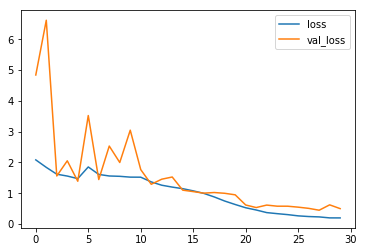

In [20]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [34]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [35]:
answer = pd.DataFrame({"prediction":y_predi})

In [36]:
answer.to_csv('results/6-5.csv',index=False, header="label")